In [1]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import glob
from controlnet.dataset import UniDataset
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset
from controlnet.softsplat import softsplat
import torchvision
import random
from residual_utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/maryamsana_98/DiffCodec-Controlling-Latent-Diffusion-for-Perceptual-Video-Compression/controlnet/softsplat.py:279: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/data/maryamsana_98/DiffCodec-Controlling-Latent-Diffusion-for-Perceptual-Video-Compression/controlnet/softsplat.py:359: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(self, tenOutgrad):


In [2]:
video_frames = glob.glob('/data2/local_datasets/test_vimeo/*/*.png')
train_dataset = UniDataset(anno_path='data/final_captions.txt',index_file= 'data/index_file_vll5.txt',
                     local_type_list= ['r1','r2', 'flow','flow_b'], resolution=256)
train_dataset.video_frames = video_frames
wrapped_dataset = WarpingDatasetWrapper(train_dataset)

In [3]:
visualize_samples(wrapped_dataset, num_samples=2)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x0 with 0 Axes>

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    wrapped_dataset, batch_size=1, shuffle=True
)

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=500,           # shorter horizon is fine for residuals
    beta_start=1e-4,                   # very low starting noise
    beta_end=0.02,                     # keep final noise moderate
    beta_schedule="squaredcos_cap_v2", # cosine schedule (better SNR retention)
    prediction_type="epsilon",         # predict noise instead of x0
    clip_sample=True,                  # keep samples bounded
    variance_type="fixed_small"        # stable for training
)

In [ ]:
xb = next(iter(train_dataloader))["residual"].to(device)[:8]
xb= xb.squeeze(0)
plt.imshow(xb.squeeze(0).permute(1,2,0).cpu().numpy())

Noisy X shape torch.Size([8, 3, 256, 256])


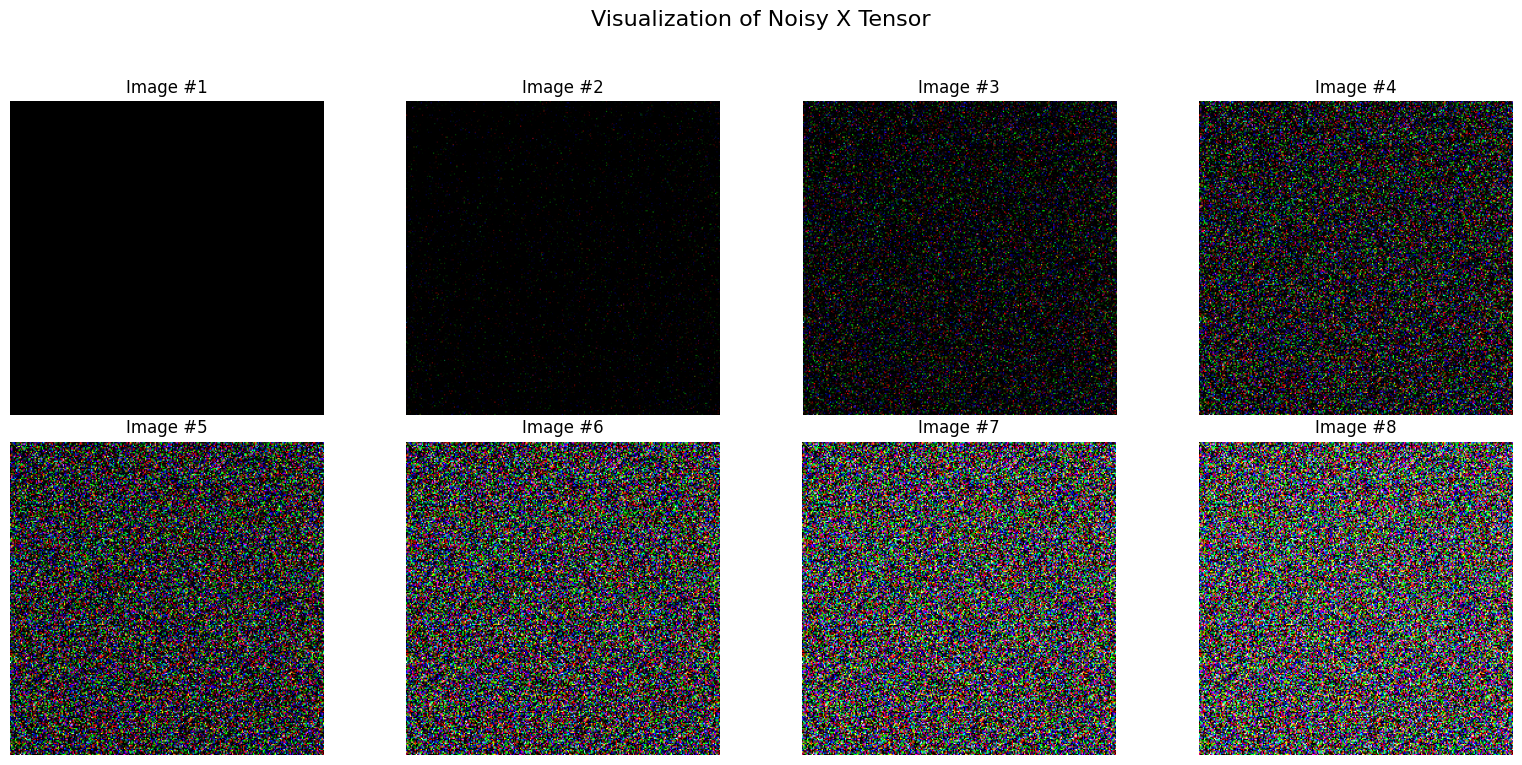

In [7]:
max_timestep = noise_scheduler.config.num_train_timesteps - 1 

# Create timesteps within the valid range [0, 499]
timesteps = torch.linspace(0, max_timestep, 8).long().to(device)

# This will now work correctly
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
# show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)
show_image_batch(noisy_xb)

In [8]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=256,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


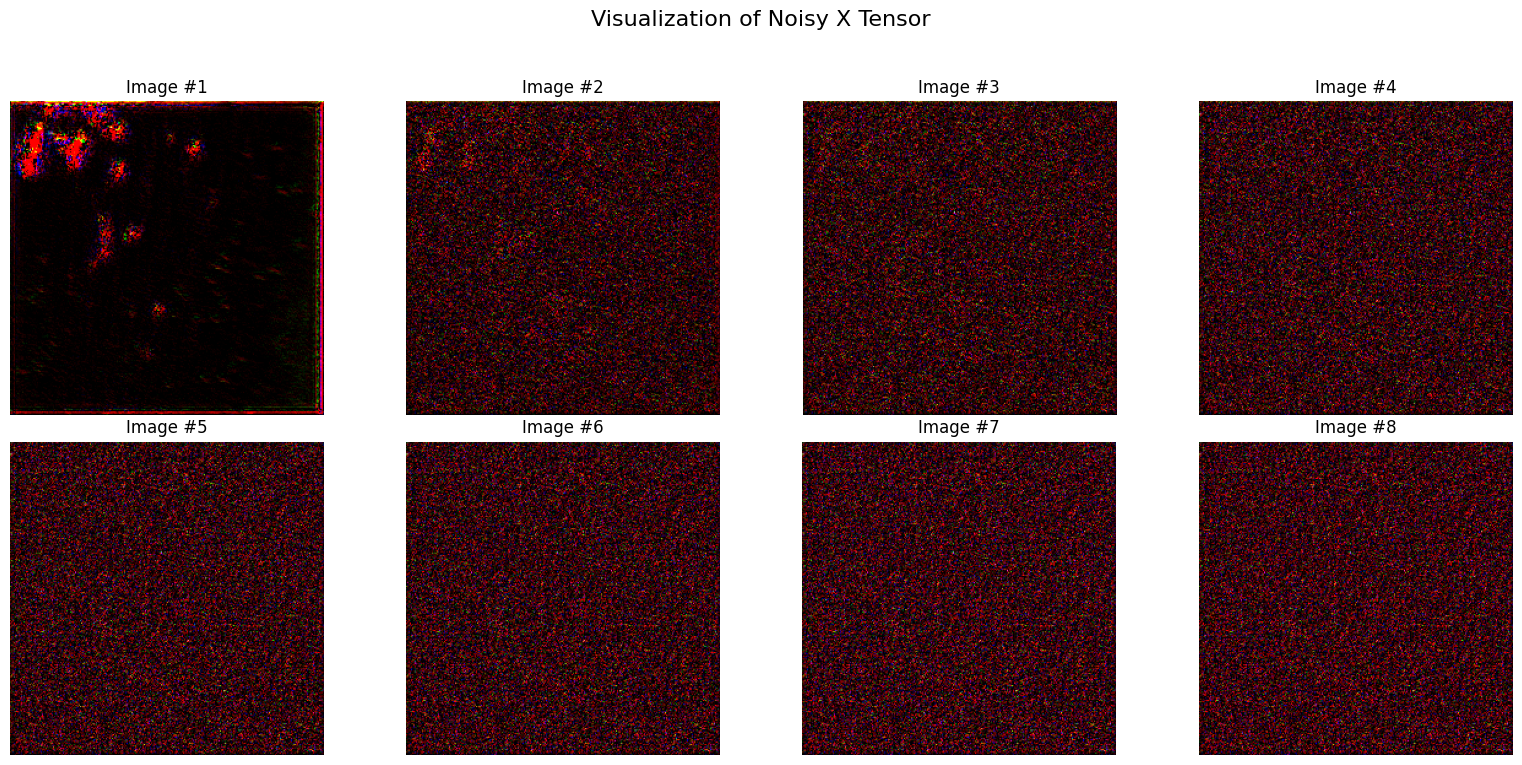

In [9]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

show_image_batch(model_prediction)

In [ ]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["residual"].squeeze(0).to(device)
        print(clean_images.shape)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/data/maryamsana_98/DiffCodec-Controlling-Latent-Diffusion-for-Perceptual-Video-Compression/residual_utils.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/data/maryamsana_98/DiffCodec-Controlling-Latent-Diffusion-for-Perceptual-Video-Compression/residual_utils.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_m

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1,

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()